In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils import *
from Evaluation import *
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

from ipywidgets import Tab, VBox
from ipyfilechooser import FileChooser

from Variables import MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, USE_HARD_GRID



# Hefekulturen

To generate a broad understanding of the p-value and its meaning in statistics, please read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665734/

## 1. Choose Files To Evaluate

Please use the FileChooser to load experiment and reference plate. 
Also choose a directory where you would like to save your results. 

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

Also, loads the plates layouts based on the file name of the reference plate. 
Make sure the filename contains "`A_`", "`B_`" or "`C_`" according to the used layout.

In [3]:
names = ['Reference Plate', 'Experiment Plate', 'Save Directory']

# Create individual FileChooser widgets for each tab
fc_reference = FileChooser('./')
fc_experiment = FileChooser('./')
fc_save = FileChooser('./')
fc_save.show_only_dirs = True

# Put the FileChooser widgets in a list
file_choosers = [fc_reference, fc_experiment, fc_save]

# Create a Tab widget with the FileChooser widgets
tab = Tab(children=file_choosers)

# Set the titles for each tab
for i, title in enumerate(names):
    tab.set_title(i, title)

# Display the tab widget
display(tab)

In [4]:
path_to_reference_plate = fc_reference.selected 
path_to_experiment_plate = fc_experiment.selected 
save_results_folder = fc_save.selected 

print(f"Current reference plate: {path_to_reference_plate}\nCurrent experiment plate: {path_to_experiment_plate}\nSave results to: {save_results_folder}\n")

x_expected, y_expected, layout_names = setup_layout(path_to_reference_plate)
os.makedirs(save_results_folder, exist_ok=True)

Current reference plate: /media/hansel/SSD/Data/Hefekulturen/Data_May_2023/Spa2/A_Gen_D3.JPG
Current experiment plate: /media/hansel/SSD/Data/Hefekulturen/Data_May_2023/Spa2/A_Cu50_D3.JPG
Save results to: /media/hansel/SSD/Data/Hefekulturen/

Use Layout A with 48 columns and 32 rows.


## 2. Open and Preprocess Images

### 2.1. Open Images as Binary

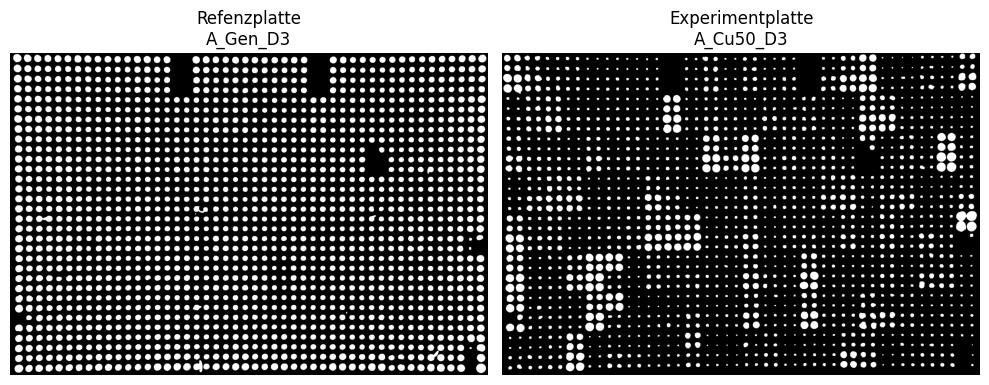

In [5]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2.2. Compute Colony Sizes

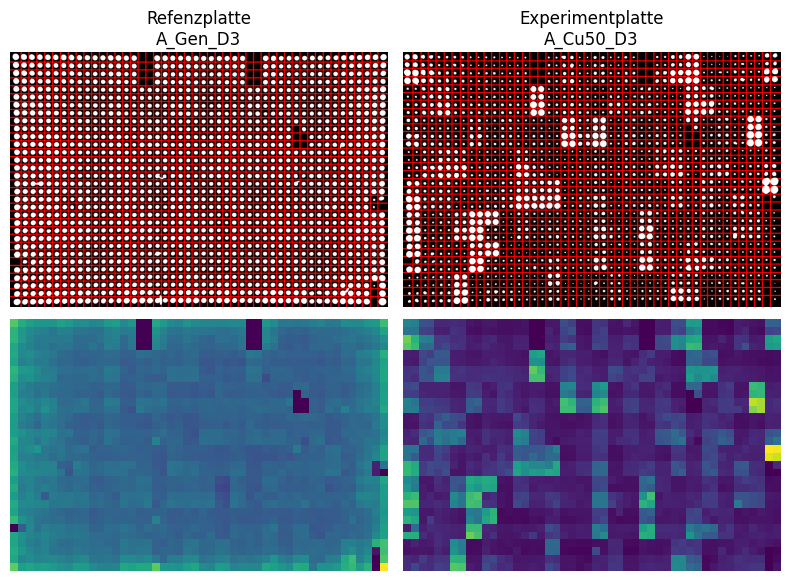

In [6]:
rgb_grid_reference, sizes_reference, x_start, x_end, y_start, y_end = compute_grid(reference_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)
rgb_grid_experiment, sizes_experiment, x_start, x_end, y_start, y_end = compute_grid(experiment_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)

if((not np.any(rgb_grid_reference == None)) and (not np.any(rgb_grid_experiment == None))):
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(min_max_norm(rgb_grid_reference))
    axs[0,1].imshow(min_max_norm(rgb_grid_experiment))
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(min_max_norm(sizes_reference)) #, cmap= "plasma")
    axs[1,1].imshow(min_max_norm(sizes_experiment)) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## 3. Evaluate
- Normalize experimental plate in relation to reference plate
    - Row/col Effect is dealt with by normalizing based on reference plate
    - Same for Edge Effect
    - Jack-Knife: removes quadruples where not all colonies have grown (markes as invalid)
- Find invalid quadruples (Exclude inaccuracies on reference plate and missing values)
- Exp1: Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple are outliers compared to other colonies
- Exp2: Find siginificant differences between row A and row B
- Saves .pdf into results folder with images

Results are sorted in such way, that first quadruples are shown that are significant in Exp1 and Exp2, while being sorted by their effect size of Exp2. 
Next, results are shown, which are only significant in Exp2 - again sorted by their effect size. 
Next, results are shown which are only significant in Exp 1 - sorted by the mean normalized size of the row with bigger growth
Next, quadruples which do not show significance in either experiments are listed
Finally, invalid quadruples are listed.

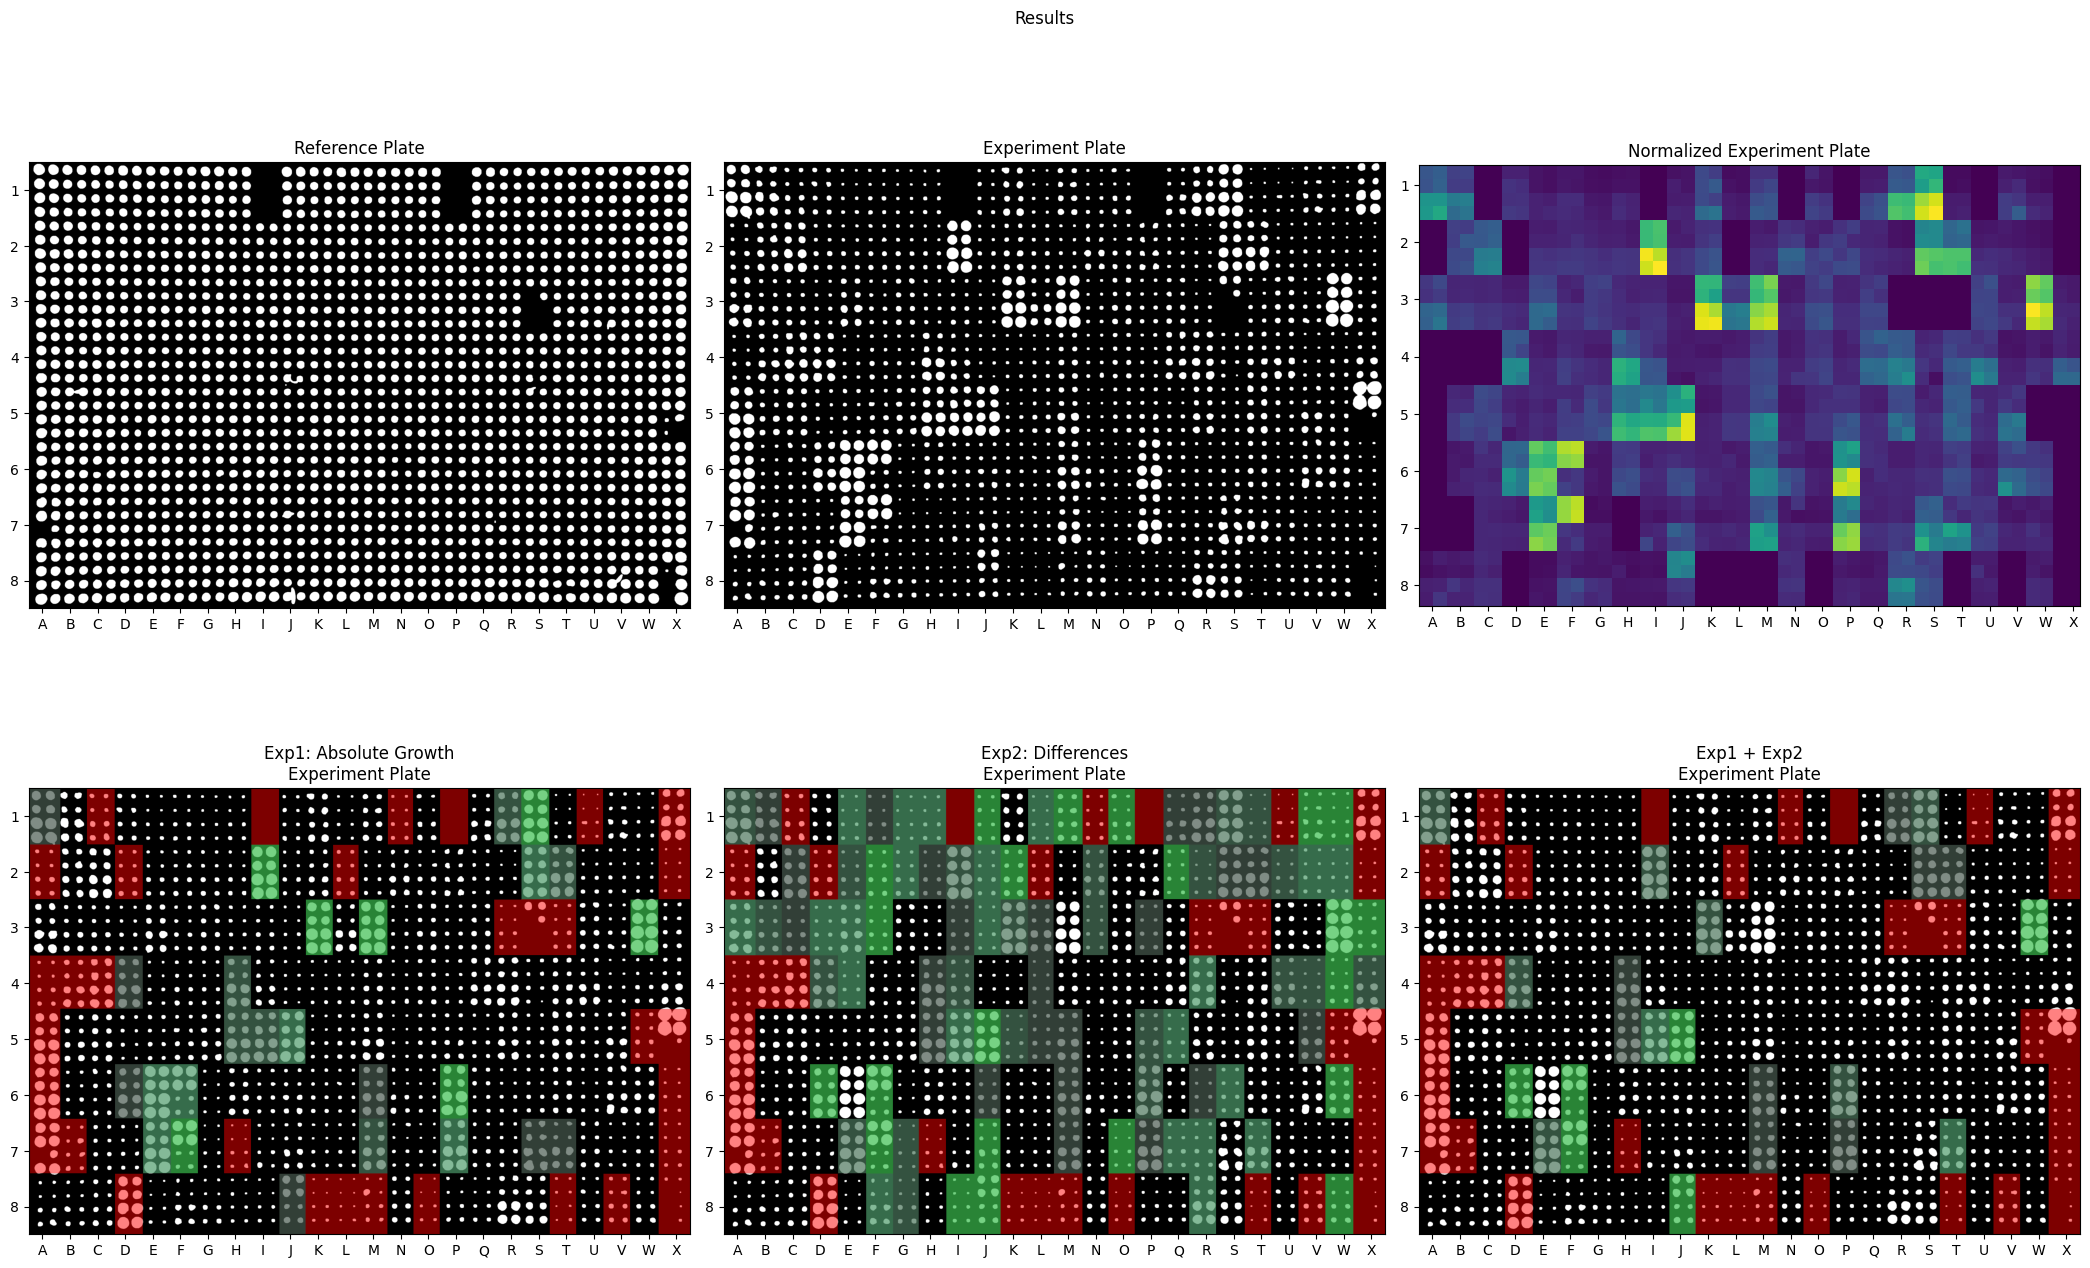

In [7]:
quadruples, minimum_size = evaluate(experiment_plate, 
                      reference_plate, 
                      sizes_experiment, 
                      sizes_reference, 
                      x_start, 
                      x_end, 
                      y_start, 
                      y_end, 
                      layout_names,
                      MIN_COLONY_SIZE, 
                      P_VALUE_NULLHYPOTHESIS, 
                      log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## 4. Save Data To Excel Sheet

In [34]:

data = {'Position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'Name': [str(quad.name) for quad in quadruples], 
        'Exp1: Significant Size': ["yes" if (quad.absolute_size>minimum_size) else "no" for quad in quadruples],
        'Exp1: Absolut Size': [quad.absolute_size for quad in quadruples],
        'Exp1: Minimum Threshold': [minimum_size for quad in quadruples],

        'Exp2: Significant Difference': ["yes" if (quad.p_value<P_VALUE_NULLHYPOTHESIS) else "no" for quad in quadruples],
        'Exp2: P-Value': [quad.p_value for quad in quadruples], 
        'Exp2: Effect Size': [quad.effect_size for quad in quadruples], 
        'Exp2: Growth Factor': [quad.growthfactor for quad in quadruples],
        
        'Is Valid' : ["valid" if quad.is_valid else "invalid" for quad in quadruples], 
        'Reason': [quad.reason for quad in quadruples],

        'Bigger Row': [quad.bigger_row for quad in quadruples],

        'A1 Normalized': [str(quad.quadrupelA.sizes[0]) for quad in quadruples], 
        'A2 Normalized': [str(quad.quadrupelA.sizes[1]) for quad in quadruples], 
        'A3 Normalized': [str(quad.quadrupelA.sizes[2]) for quad in quadruples], 
        'A4 Normalized': [str(quad.quadrupelA.sizes[3]) for quad in quadruples], 
        'B1 Normalized': [str(quad.quadrupelB.sizes[0]) for quad in quadruples], 
        'B2 Normalized': [str(quad.quadrupelB.sizes[1]) for quad in quadruples], 
        'B3 Normalized': [str(quad.quadrupelB.sizes[2]) for quad in quadruples], 
        'B4 Normalized': [str(quad.quadrupelB.sizes[3]) for quad in quadruples],

        'A1 Raw Experiment': [str(quad.quadrupelA.sizes_exp[0]) for quad in quadruples], 
        'A2 Raw Experiment': [str(quad.quadrupelA.sizes_exp[1]) for quad in quadruples], 
        'A3 Raw Experiment': [str(quad.quadrupelA.sizes_exp[2]) for quad in quadruples], 
        'A4 Raw Experiment': [str(quad.quadrupelA.sizes_exp[3]) for quad in quadruples], 
        'B1 Raw Experiment': [str(quad.quadrupelB.sizes_exp[0]) for quad in quadruples], 
        'B2 Raw Experiment': [str(quad.quadrupelB.sizes_exp[1]) for quad in quadruples], 
        'B3 Raw Experiment': [str(quad.quadrupelB.sizes_exp[2]) for quad in quadruples], 
        'B4 Raw Experiment': [str(quad.quadrupelB.sizes_exp[3]) for quad in quadruples],

        'A1 Raw Reference': [str(quad.quadrupelA.sizes_ref[0]) for quad in quadruples], 
        'A2 Raw Reference': [str(quad.quadrupelA.sizes_ref[1]) for quad in quadruples], 
        'A3 Raw Reference': [str(quad.quadrupelA.sizes_ref[2]) for quad in quadruples], 
        'A4 Raw Reference': [str(quad.quadrupelA.sizes_ref[3]) for quad in quadruples], 
        'B1 Raw Reference': [str(quad.quadrupelB.sizes_ref[0]) for quad in quadruples], 
        'B2 Raw Reference': [str(quad.quadrupelB.sizes_ref[1]) for quad in quadruples], 
        'B3 Raw Reference': [str(quad.quadrupelB.sizes_ref[2]) for quad in quadruples], 
        'B4 Raw Reference': [str(quad.quadrupelB.sizes_ref[3]) for quad in quadruples],
} 

df = pd.DataFrame(data=data)  
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")

print(f"INFO::Evaluation done. Results can be found here: {os.path.abspath(save_results_folder)}")
open_file_explorer(save_results_folder)


INFO::Evaluation done. Results can be found here: /media/hansel/SSD/Data/Hefekulturen
